<a href="https://colab.research.google.com/github/ParbatiDebbarma/Adease-Time-Series-Analysis/blob/main/AdEase_Time_Series_Business_Case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AdEase Time Series Business Case**

# **About AdEase**

Ad Ease is an ads and marketing based company helping businesses elicit maximum clicks @ minimum cost. AdEase is an ad infrastructure to help businesses promote themselves easily, effectively, and economically. The interplay of 3 AI modules - Design, Dispense, and Decipher, come together to make it this an end-to-end 3 step process digital advertising solution for all.

# **Problem Statement**

You are working in the Data Science team of Ad ease trying to understand the per page view report for different wikipedia pages for 550 days, and forecasting the number of views so that you can predict and optimize the ad placement for your clients. You are provided with the data of 145k wikipedia pages and daily view count for each of them. Your clients belong to different regions and need data on how their ads will perform on pages in different languages.

# **Data Dictionary**

There are two csv files

- **train_1.csv:**
In the csv file, each row corresponds to a particular
article and each column corresponds to a particular date. The values are the number of visits on that date.

 The page name contains data in this format:

 **SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN**
having information about the page name, the main domain, the device type used to access the page, and also the request origin(spider or browser agent)


- **Exog_Campaign_eng:**
This file contains data for the dates which had a campaign or significant event that could affect the views for that day. The data is just for pages in English.

 There’s 1 for dates with campaigns and 0 for remaining dates. It is to be treated as an exogenous variable for models when training and forecasting data for pages in English

# **Concepts Tested:**

- Exploratory data analysis

- Time Series forecasting- ARIMA, SARIMAX, and Prophet



---



In [100]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import warnings

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning


# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Suppress specific warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=ValueWarning)

In [101]:
train_df = pd.read_csv('/content/train_1.csv')
train_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [102]:
print(f'No. of Rows in the train df : {train_df.shape[0]}\nNo. of Columns in the train df : {train_df.shape[1]}')

No. of Rows in the train df : 145063
No. of Columns in the train df : 551


In [103]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [104]:
exog_df = pd.read_csv('/content/Exog_Campaign_eng')
exog_df.head()

,Exog
0,0
1,0
2,0
3,0
4,0


In [105]:
print(f'No. of Rows in the exog df : {exog_df.shape[0]}\nNo. of Columns in the exog df : {exog_df.shape[1]}')

No. of Rows in the exog df : 550
No. of Columns in the exog df : 1


In [106]:
exog_df.value_counts()

,count
Exog,
0,496
1,54


# **Null Values Detection**

Let’s check the presence and pattern of missing values. Since each row represents a time series for a Wikipedia page, missing values could also mean:

- Page was not live on certain dates.
- View count was not recorded (data issue).
- Zero traffic (but incorrectly left blank).

**Nulls per Page**

In [107]:
# Count of null values per row
null_counts_per_page = train_df.iloc[:, 1:551].isnull().sum(axis=1)

# Number of rows that have missing values.
pages_with_nulls = (null_counts_per_page > 0).sum()
print(f"Pages with missing values: {pages_with_nulls} out of {train_df.shape[0]}")

Pages with missing values: 27786 out of 145063


**Nulls per Day**

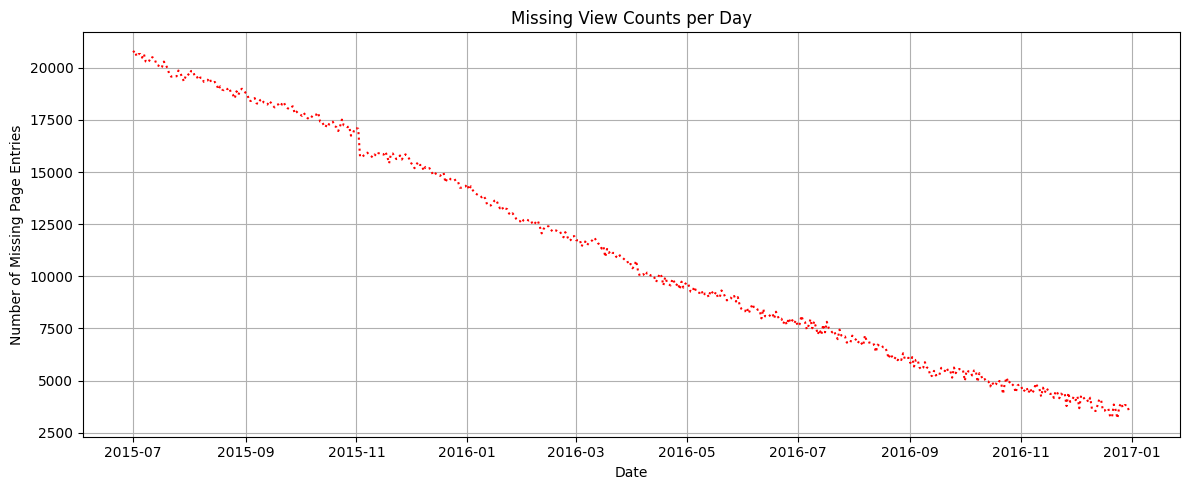

In [108]:
# Count of nulls per date
missing_per_day = train_df.iloc[:, 1:551].isnull().sum(axis=0)

# Convertinf index to datetime
missing_per_day.index = pd.to_datetime(missing_per_day.index)

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(missing_per_day, linestyle='dotted', color='red')
plt.title('Missing View Counts per Day')
plt.xlabel('Date')
plt.ylabel('Number of Missing Page Entries')
plt.grid(True)
plt.tight_layout()
plt.show()


**Observations:**

- The plot suggests that not all pages have recorded views data starting from July, 2015.
- As we move closer to the year 2016, the amount of missing data gradually decreases.
- There is a consistent downward trend in the number of missing page entries over time. This suggests that more Wikipedia pages started reporting view data as time progressed — likely due to improved tracking, new page creation, or stabilization of the data collection process.
- Many pages seem to have joined the dataset after July 2015 (the start date), as evidenced by the high initial missing count. This implies that a portion of the 145k pages were created or started recording traffic only partway through the time window.
- By late 2016, the number of missing entries per day plateaus at a much lower value (around ~3,000–5,000), indicating a more complete and stable dataset in the later months. This might be the most reliable period for forecasting.

## **Null Treatment**

Let’s drop only pages where more than, say, 80% of the data is missing. That’s around 440+ missing days out of 550.

In [109]:
# Calculating number of missing values per row (i.e., per page)
null_counts = train_df.iloc[:, 1:551].isnull().sum(axis=1)

# Dropping pages where more than 80% of data is missing
threshold = 0.8 * 550
clean_train_df = train_df[null_counts <= threshold].copy()

print(f"Dropped {train_df.shape[0] - clean_train_df.shape[0]} pages due to excessive missing data.")

Dropped 4310 pages due to excessive missing data.


In [110]:
print("train_df:", train_df.shape)
print("clean_train_df:", clean_train_df.shape)

train_df: (145063, 551)
clean_train_df: (140753, 551)


In [111]:
df = clean_train_df.iloc[:, 1:551]

df = df.ffill(axis=1).bfill(axis=1)

clean_train_df.iloc[:, 1:551] = df

In [112]:
clean_train_df.isnull().sum().sum()

np.int64(0)

# **Exploratory Data Analysis - EDA**

Since the Page column in train_df contains metadata embedded in a string, we can extract meaningful components such as:

- Article name(Specific Name)
- Language code
- Access type
- Access origin

In [113]:
clean_train_df['Page'].sample(20)

,Page
88448,庄司哲郎_ja.wikipedia.org_desktop_all-agents
137531,Energiegefilterte_Transmissionselektronenmikro...
89405,6月10日_ja.wikipedia.org_desktop_all-agents
84337,Manual:User_rights_www.mediawiki.org_all-acces...
4430,Anxiete_fr.wikipedia.org_desktop_all-agents
25609,Abdelhafid_Metalsi_fr.wikipedia.org_all-access...
19509,Группы_смерти_ru.wikipedia.org_mobile-web_all-...
37874,Emmanuel_Macron_en.wikipedia.org_all-access_al...
120168,あいだもも_ja.wikipedia.org_all-access_all-agents
121688,向田邦子_ja.wikipedia.org_all-access_all-agents


In [114]:
# Splitting metadata from Page column
page_meta = clean_train_df['Page'].str.extract(
    r'(?P<Article>.+)_(?P<Language>[a-z\-]+)\.wikipedia\.org_(?P<Access_Type>[^_]+)_(?P<Access_Origin>[^_]+)$'
)

clean_train_df = clean_train_df.join(page_meta)

In [115]:
clean_train_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Article,Language,Access_Type,Access_Origin
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,14.0,20.0,22.0,19.0,18.0,20.0,2NE1,zh,all-access,spider
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,9.0,30.0,52.0,45.0,26.0,20.0,2PM,zh,all-access,spider
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,4.0,4.0,6.0,3.0,4.0,17.0,3C,zh,all-access,spider
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,16.0,11.0,17.0,19.0,10.0,11.0,4minute,zh,all-access,spider
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,...,3.0,11.0,27.0,13.0,36.0,10.0,52_Hz_I_Love_You,zh,all-access,spider


In [116]:
df = clean_train_df.copy()

**No. of Languages**

In [117]:
df['Language'].nunique()

7

There are 7 different languages of wikipedia pages in the dataframe.

In [118]:
# Creating a map to replace the language code with corresponding language for easy understanding

language_map = {
    "en": "English",
    "ja": "Japanese",
    "de": "German",
    "fr": "French",
    "zh": "Chinese",
    "ru": "Russian",
    "es": "Spanish"
}

#df["Language"] = df["Language"].replace(to_replace=language_map)
# Replace NaNs with 'Unknown' and then map codes to full language names
df["Language"] = df["Language"].fillna("Unknown").replace(language_map)

In [119]:
df['Language'].unique()

array(['Chinese', 'French', 'English', 'Unknown', 'Russian', 'German',
       'Japanese', 'Spanish'], dtype=object)

**No. of Specific Names**

In [120]:
df['Article'].nunique() #Number of Articles

40822

There are 40822 unique Articles(Specific Names)

In [121]:
df.duplicated().sum()

np.int64(0)

In [122]:
clean_train_df[clean_train_df["Article"] == "2NE1"]

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Article,Language,Access_Type,Access_Origin
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,14.0,20.0,22.0,19.0,18.0,20.0,2NE1,zh,all-access,spider
27965,2NE1_zh.wikipedia.org_all-access_all-agents,785.0,725.0,641.0,704.0,690.0,657.0,670.0,698.0,791.0,...,709.0,652.0,654.0,551.0,643.0,572.0,2NE1,zh,all-access,all-agents
60570,2NE1_zh.wikipedia.org_desktop_all-agents,540.0,514.0,400.0,458.0,467.0,432.0,441.0,490.0,573.0,...,416.0,410.0,411.0,333.0,424.0,361.0,2NE1,zh,desktop,all-agents
105110,2NE1_zh.wikipedia.org_mobile-web_all-agents,238.0,211.0,239.0,244.0,219.0,223.0,226.0,203.0,213.0,...,290.0,239.0,237.0,216.0,217.0,209.0,2NE1,zh,mobile-web,all-agents


- Multiple entries for the same article indicate that Wikipedia tracks **page views separately based on device type and access origin**.
- These are **not duplicates** but represent different sources of traffic for the same content.
- This allows for a more detailed understanding of how and where users are accessing information.

**Total vs Average Views Per Page**

In [123]:
df['Total_Views'] = df.iloc[:, 1:551].sum(axis=1)
df['Average_Views'] = df.iloc[:, 1:551].mean(axis=1)

# Basic stats on total and average views
print(df[['Total_Views', 'Average_Views']].describe())


        Total_Views  Average_Views
count  1.407530e+05   1.407530e+05
mean   7.641106e+05   1.389292e+03
std    4.163213e+07   7.569478e+04
min    0.000000e+00   0.000000e+00
25%    1.810000e+04   3.290909e+01
50%    1.473240e+05   2.678618e+02
75%    4.738330e+05   8.615145e+02
max    1.206618e+10   2.193851e+07


In [124]:
df.iloc[:, -5:].head()

,Language,Access_Type,Access_Origin,Total_Views,Average_Views
0,Chinese,all-access,spider,11966.0,21.756364
1,Chinese,all-access,spider,13966.0,25.392727
2,Chinese,all-access,spider,2862.0,5.203636
3,Chinese,all-access,spider,9419.0,17.125455
4,Chinese,all-access,spider,13720.0,24.945455


 **Statistical Summary**

In [125]:
df.iloc[:, -5:].describe(include = 'object')

,Language,Access_Type,Access_Origin
count,140753,124132,124132
unique,8,3,2
top,English,all-access,all-agents
freq,23570,64309,94140


**Views on the basis of Language**

In [126]:
lang_summary = df.groupby('Language')[['Total_Views', 'Average_Views']].mean().sort_values(by='Total_Views', ascending=False)
print(lang_summary.head(10))


           Total_Views  Average_Views
Language                             
English   2.573174e+06    4678.497310
Spanish   6.910679e+05    1256.487109
Russian   5.571851e+05    1013.063755
German    5.114455e+05     929.900972
Japanese  4.386856e+05     797.610247
French    3.719539e+05     676.279868
Chinese   2.022875e+05     367.795451
Unknown   7.931959e+04     144.217445


# **Data Visualization**

## **Univariate Analysis**

###**Top Languages by Number of Pages**

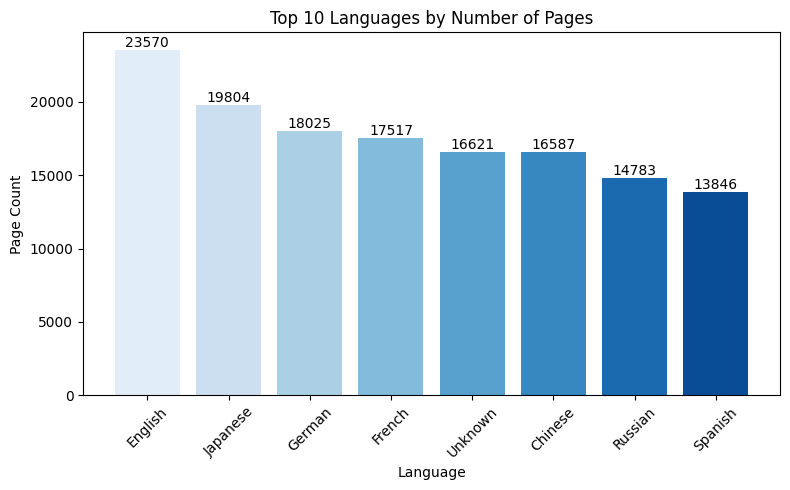

In [127]:
# Data
lang_counts = df['Language'].value_counts().head(10)
colors = sns.color_palette('Blues', len(lang_counts))

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(lang_counts.index, lang_counts.values, color=colors)

# Adding count labels on top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.title('Top 10 Languages by Number of Pages')
plt.xlabel('Language')
plt.ylabel('Page Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Observations:**

- English dominates the dataset with the highest number of pages (~23.5k), indicating its strong presence and likely high traffic potential.
- Japanese and German follow next, each with over 18k pages — showing significant content and engagement in these regions.
- There's a gradual decline from French to Spanish, suggesting a relatively balanced but lower representation among non-English European and Asian languages.



### **Access Type Distribution**

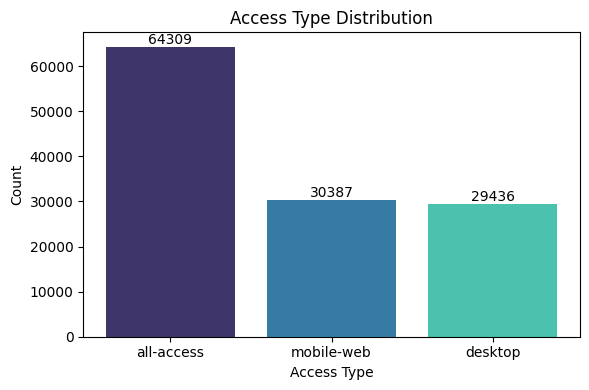

In [128]:
access_counts = df['Access_Type'].value_counts()
colors = sns.color_palette('mako', len(access_counts))

plt.figure(figsize=(6, 4))
bars = plt.bar(access_counts.index, access_counts.to_numpy(), color=colors)


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.title('Access Type Distribution')
plt.xlabel('Access Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### **Perecntage Distribution of Acess_Type**

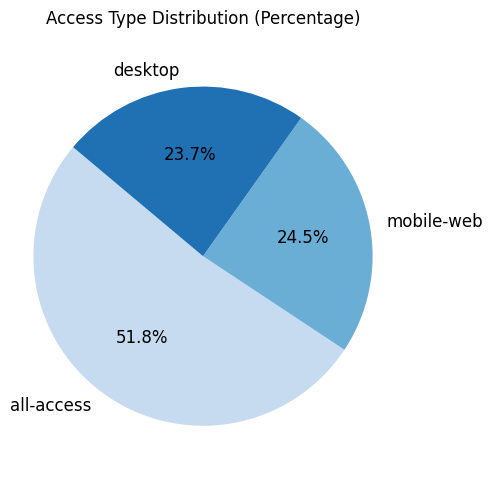

In [129]:
access_counts = df['Access_Type'].value_counts()
labels = access_counts.index.tolist()      # Converting Index to list
sizes = access_counts.values.tolist()      # Converting values to list
colors = sns.color_palette('Blues',len(labels))

#Plotting
plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors,
        textprops={'fontsize': 12})
plt.title('Access Type Distribution (Percentage)', fontsize=12)
plt.axis('equal')  # Keeps the pie chart circular
plt.tight_layout()
plt.show()


**Observations:**

- "All-access" pages dominate the dataset with over 64k entries(51.8%) — more than double that of either "mobile-web"(24.5%) or "desktop"(23.7%), indicating a preference for aggregating traffic across platforms.
- Mobile-web (30k+) and desktop (29k+) are nearly balanced, suggesting that user behavior is fairly split between devices.
- The presence of all three types confirms that the dataset supports device-specific as well as combined access analysis, which is valuable for ad targeting and traffic segmentation.



### **Access Origin Distribution**

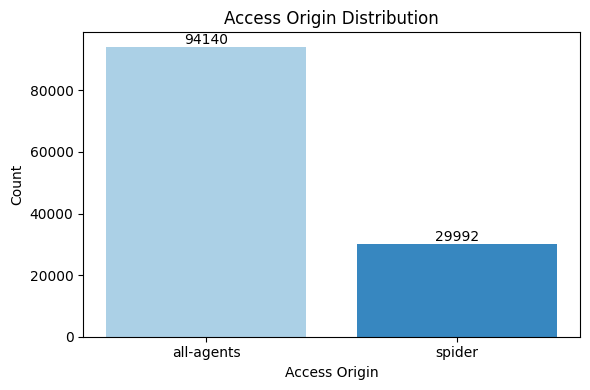

In [130]:
origin_counts = df['Access_Origin'].value_counts()
colors = sns.color_palette('Blues', len(origin_counts))

# Converting index and values to lists
labels = origin_counts.index.tolist()
heights = origin_counts.values.tolist()

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, heights, color=colors)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.title('Access Origin Distribution')
plt.xlabel('Access Origin')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


**Observations:**
- "All-agents" traffic is overwhelmingly dominant with over 94k entries, showing that most page view data includes both human and automated (bot) traffic combined.
- "Spider" (bot-originated) traffic accounts for nearly 30k pages, which is significant — bots make up a notable portion of traffic sources.
- The distinction between human and spider access is important for ad optimization, as real user views (from all-agents) are typically more valuable for advertisers.

## **Bivariate Analysis**

### **Language vs Access Type**

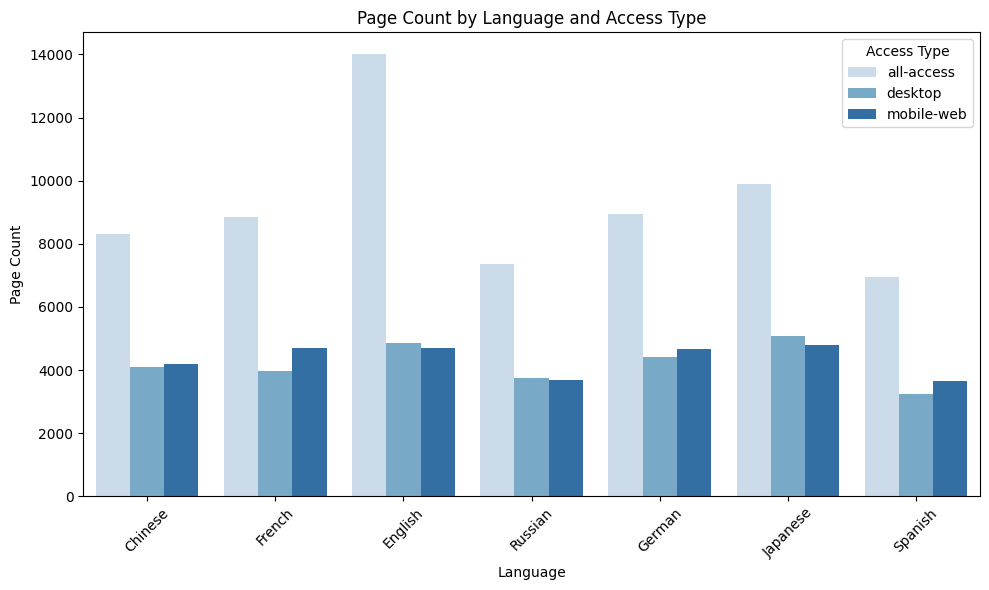

In [131]:
# Filtering top 7 languages excluding 'Unknown'
top_langs = df[df['Language'] != 'Unknown']['Language'].value_counts().head(8).index
subset = df[df['Language'].isin(top_langs)]

plt.figure(figsize=(10, 6))
sns.countplot(data=subset, x='Language', hue='Access_Type', palette='Blues')
plt.title('Page Count by Language and Access Type')
plt.xlabel('Language')
plt.ylabel('Page Count')
plt.xticks(rotation=45)
plt.legend(title='Access Type')
plt.tight_layout()
plt.show()


**Observations:**

- The plot shows that English pages have the highest number of entries across all access types, with a noticeable lead in the all-access category. This suggests a significantly higher presence or popularity of English-language content.

- Across most languages, desktop and mobile-web access types have fairly similar page counts, indicating a balanced usage pattern between devices.

- Spanish and Russian pages appear to have relatively lower counts compared to other major languages like French, German, or Japanese, which may reflect fewer created pages or lower engagement in those languages.

### **Language by Access Origin**

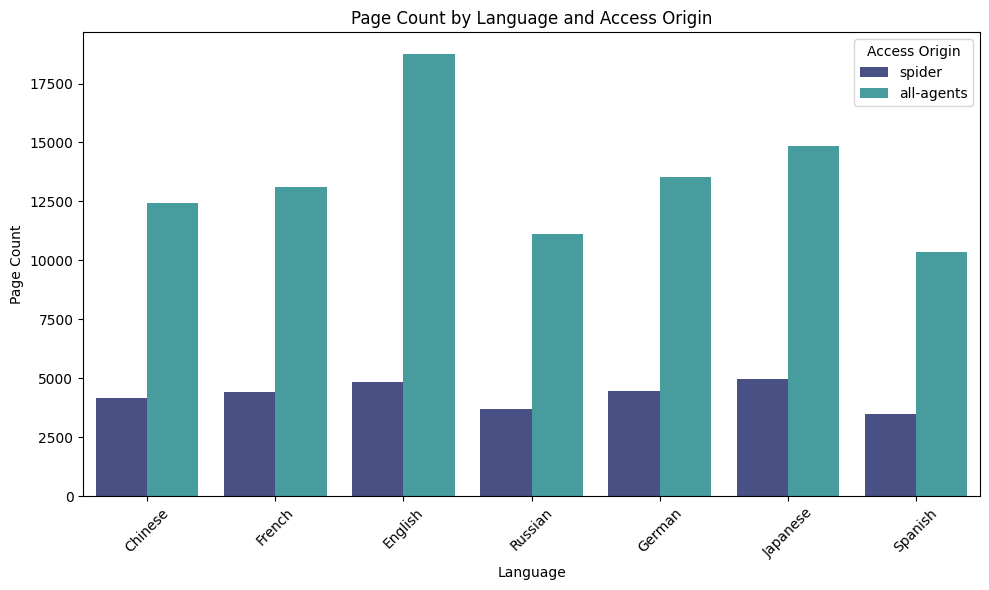

In [132]:
plt.figure(figsize=(10, 6))
sns.countplot(data=subset, x='Language', hue='Access_Origin', palette='mako')
plt.title('Page Count by Language and Access Origin')
plt.xlabel('Language')
plt.ylabel('Page Count')
plt.xticks(rotation=45)
plt.legend(title='Access Origin')
plt.tight_layout()
plt.show()

**Observations:**
- English pages have the highest count from both origins, with a particularly strong lead in the all-agents category.
- Across all languages, all-agents access consistently dominates over spider access, suggesting higher engagement from real users compared to automated bots.
- Japanese and English show relatively higher spider-based access compared to others, indicating more automated indexing or crawling activity on pages in those languages.

### **Total views by Access Type**

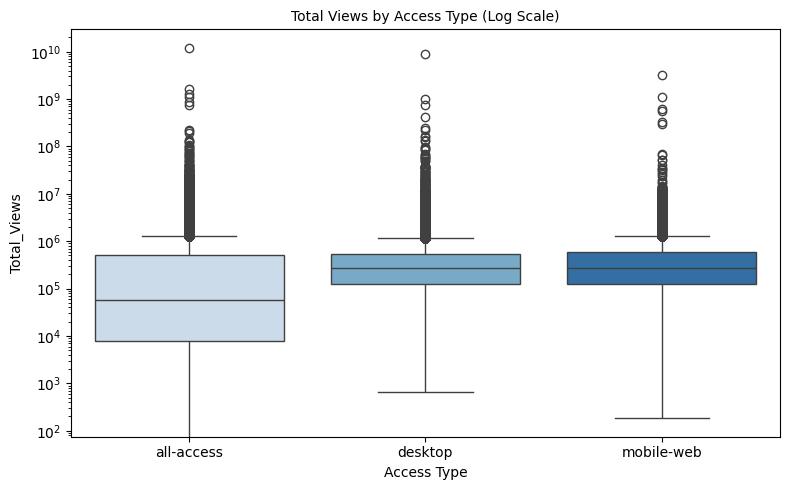

In [133]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Access_Type', y='Total_Views', palette='Blues')
plt.yscale('log')  # Because view counts are skewed
plt.title('Total Views by Access Type (Log Scale)', fontdict={'fontsize': 10})
plt.xlabel('Access Type')
plt.tight_layout()
plt.show()

**Observations:**

- All three access types—all-access, desktop, and mobile-web show a highly skewed distribution, with a large number of extreme outliers having very high view counts.
- The all-access category has a higher median and broader spread in total views compared to desktop and mobile-web, indicating it captures more overall traffic per page.
- Despite using a log scale, the presence of dense outliers at the top suggests a small number of pages receive disproportionately high traffic regardless of access type.

### **Total Views by Access Origin**

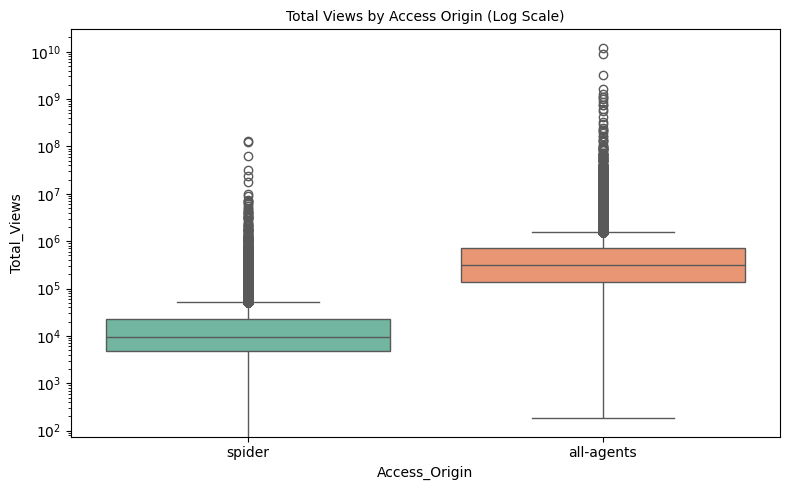

In [134]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Access_Origin', y='Total_Views', palette='Set2')
plt.yscale('log')
plt.title('Total Views by Access Origin (Log Scale)',fontdict={'fontsize': 10} )
plt.tight_layout()
plt.show()

**Observations:**

- Pages accessed via all-agents generally receive significantly higher total views than those accessed by spiders, as indicated by a higher median and a wider interquartile range.

- The spider access origin shows much lower total views overall, which makes sense as this reflects automated bot traffic rather than real user engagement.

- Both access origins have a high number of outliers, but the range and density of extreme high-traffic pages are greater for all-agents, suggesting that top-performing pages attract much more human traffic.



---



Let's check how each language performs over time — using the average daily views per language.

In [135]:
df.shape

(140753, 557)

In [136]:
#Defining the date columns
date_cols = df.columns[1:551]


# Grouping by Language and calculate the mean of each date column
lang_daily_avg_df = df.groupby('Language')[date_cols].mean()

#Transposing for Time Series Format
lang_ts = lang_daily_avg_df.T  # Now rows = dates, columns = languages
lang_ts.index = pd.to_datetime(lang_ts.index)  # Converting to datetime

lang_ts.head()

Language,Chinese,English,French,German,Japanese,Russian,Spanish,Unknown
2015-07-01,296.923434,3882.045906,521.526346,805.680444,627.838063,709.834743,1128.350137,98.503820
2015-07-02,297.270031,3870.413237,524.626934,795.671567,716.563270,720.913820,1079.429149,102.838157
2015-07-03,295.594502,3689.199151,505.963807,766.485270,650.141487,673.277887,994.689008,97.618134
2015-07-04,297.984204,3829.017310,538.032254,709.140804,809.232226,637.411148,935.288170,84.622165
2015-07-05,314.731657,3945.073950,528.933322,812.993065,777.449202,674.039708,1015.008089,92.817761


### **All the languages as Time Series**

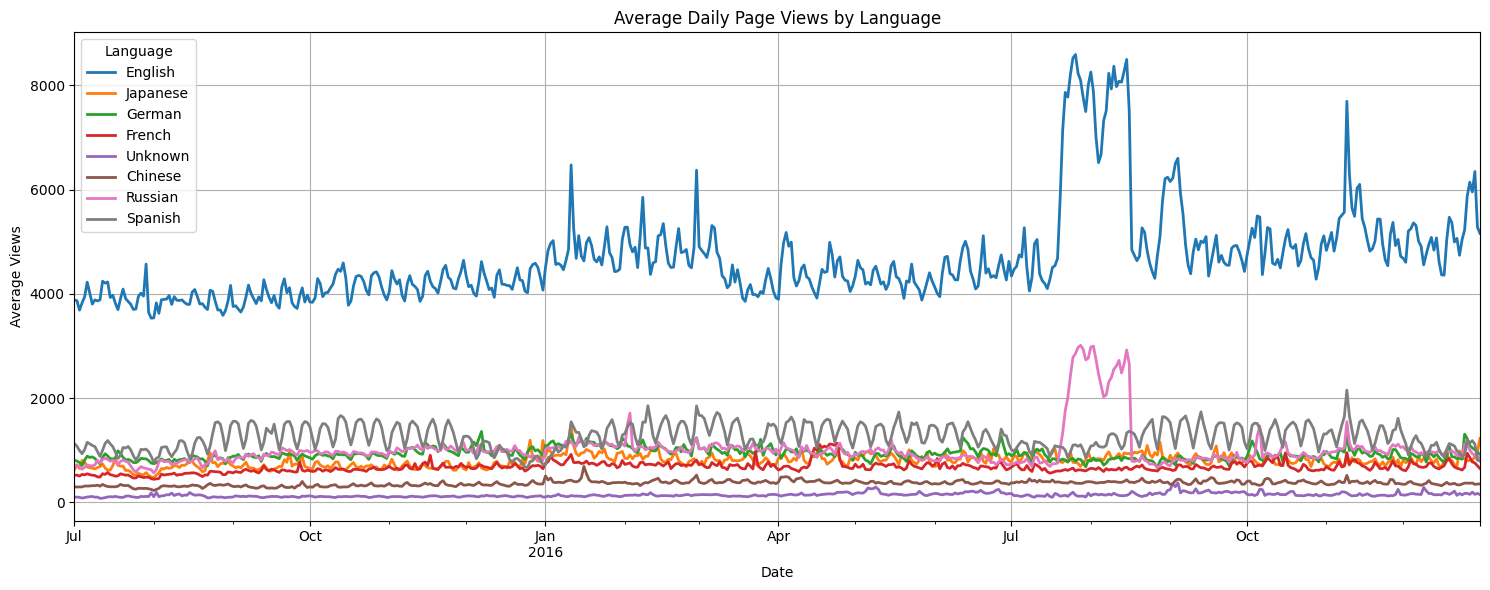

In [137]:
top_langs = df['Language'].value_counts().index

lang_ts[top_langs].plot(figsize=(15, 6), linewidth=2)
plt.title('Average Daily Page Views by Language')
plt.xlabel('Date')
plt.ylabel('Average Views', fontdict={'fontsize': 10} )
plt.grid(True)
plt.tight_layout()
plt.show()

### **Patterns of the language English in the dataframe**

In [138]:
df_en = lang_ts["English"]
df_en.head()

,English
2015-07-01,3882.045906
2015-07-02,3870.413237
2015-07-03,3689.199151
2015-07-04,3829.017310
2015-07-05,3945.073950


In [139]:
# Converting the 'English' series from lang_ts to a DataFrame and reset the index
df_en = lang_ts["English"].to_frame().reset_index()

# Renaming the columns for clarity
df_en = df_en.rename(columns={df_en.columns[0]: 'date', df_en.columns[1]: 'views'})

# Setting 'date' column as the index for time series analysis
df_en.set_index('date', inplace=True)


df_en.head()

,views
date,
2015-07-01,3882.045906
2015-07-02,3870.413237
2015-07-03,3689.199151
2015-07-04,3829.017310
2015-07-05,3945.073950


## **Additive Decomposition**

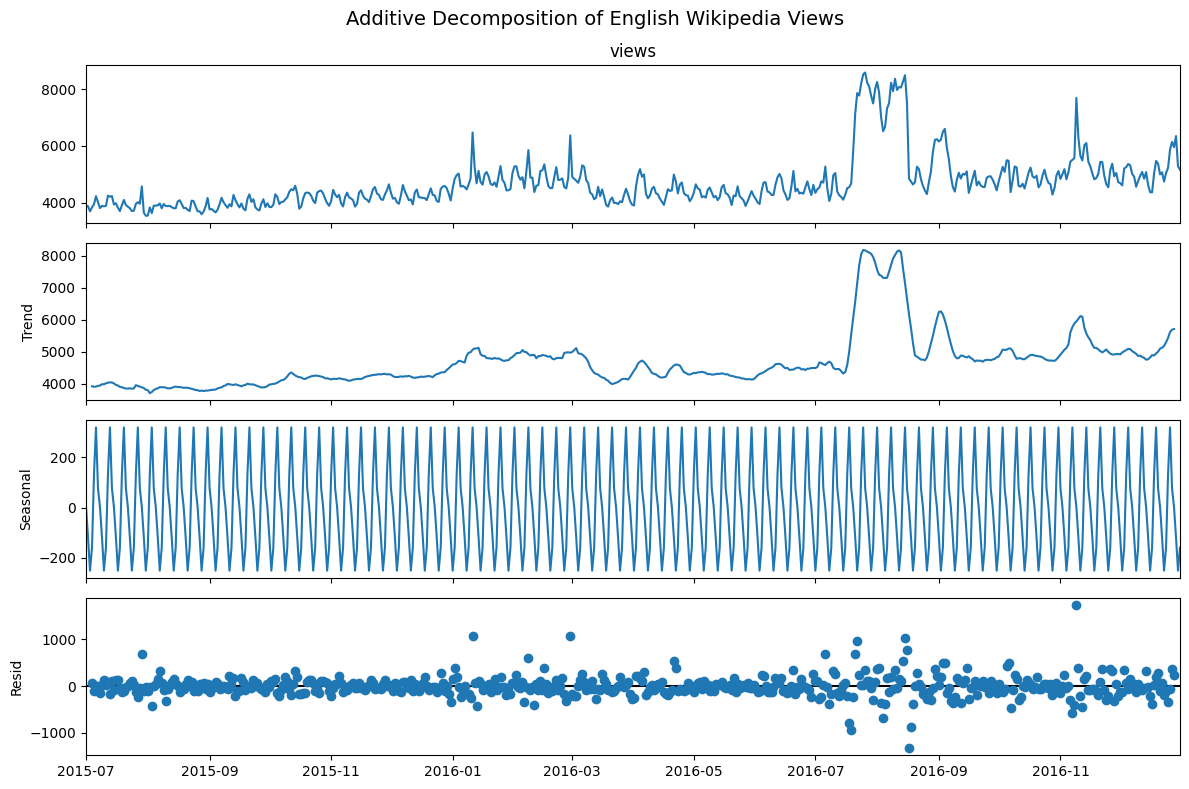

In [140]:
# Performing additive decomposition
decomposition = seasonal_decompose(df_en['views'], model='additive', period=7)  # assuming weekly seasonality

# Plotting the decomposition
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Additive Decomposition of English Wikipedia Views', fontsize=14)
plt.tight_layout()
plt.show()


<Axes: xlabel='date'>

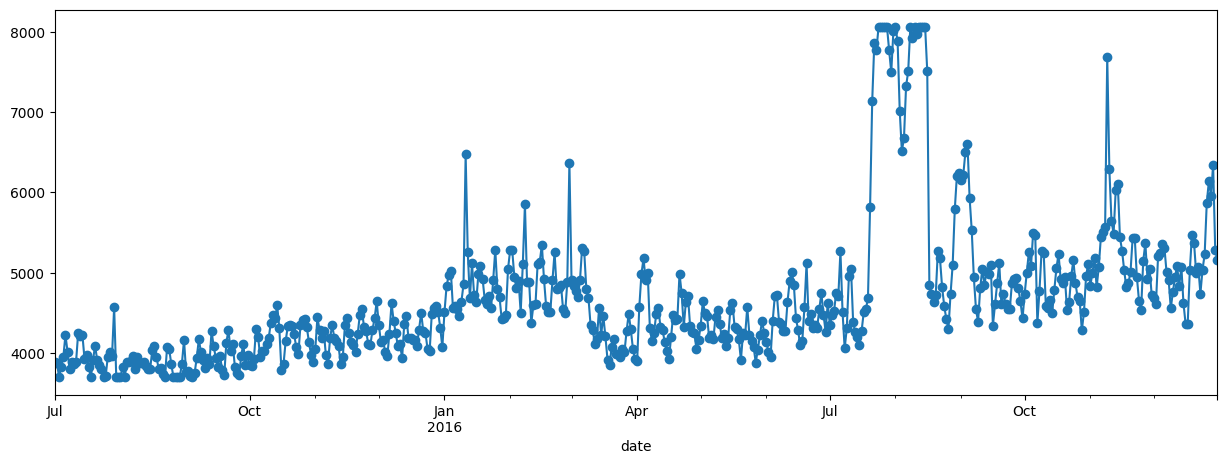

In [141]:
# Linear interpolation
df_en.views = df_en.views.interpolate(method='linear')

# Anomalies - clip quantiles
df_en.views = df_en.views.clip(upper=df_en.views.quantile(0.98), lower=df_en.views.quantile(0.02))

# Plot
df_en.views.plot(style='-o', figsize=(15,5))

**Key Observations:**

- There are clear spikes in view counts (possibly viral topics or campaign effects).
- A noticeable upward trend mid-2016 suggests growth or a big event.
- The use of quantile clipping helped avoid extreme distractions while still showing behavior.

## **ACF/PACF Plots**

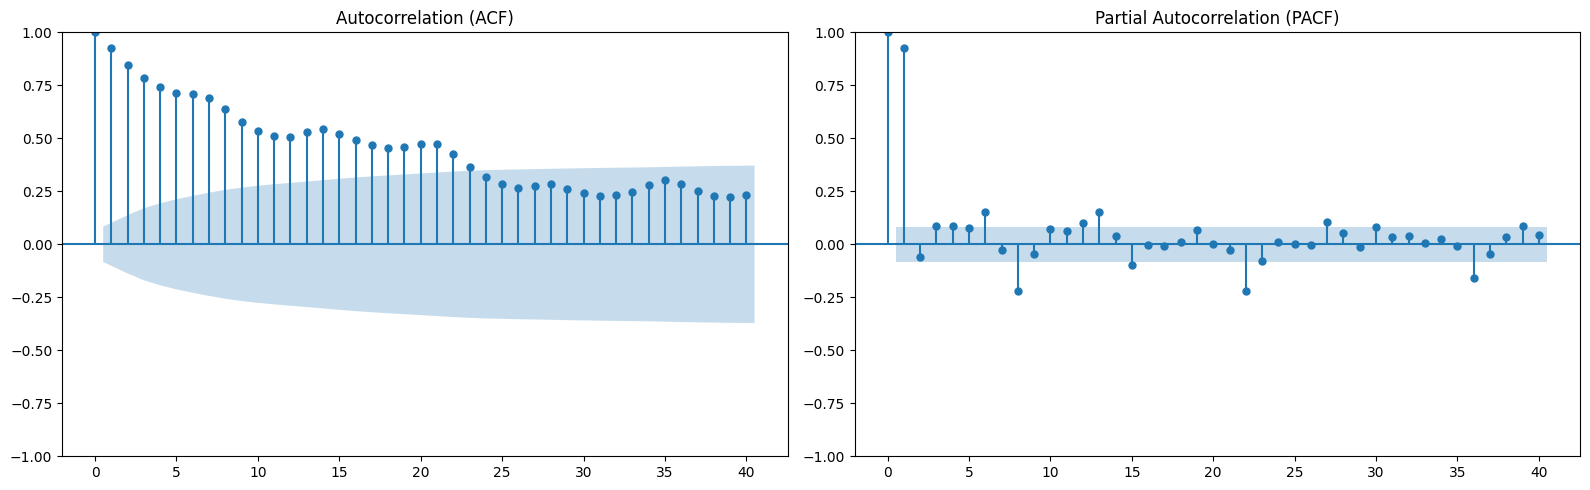

In [142]:
# Dropping NA just in case (for safe autocorrelation calculation)
ts = df_en['views'].dropna()

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(ts, lags=40, ax=axes[0], title='Autocorrelation (ACF)')
plot_pacf(ts, lags=40, ax=axes[1], title='Partial Autocorrelation (PACF)', method='ywm')

plt.tight_layout()
plt.show()


**Observations:**

- **Strong autocorrelation at lag 1 in ACF**
The ACF plot shows a very high correlation at lag 1, which gradually decreases — indicating that the series is highly dependent on its recent past, and exhibits persistence or trend-like behavior.
- **PACF cuts off sharply after lag 1**
The PACF shows a significant spike only at lag 1, with the rest near zero — suggesting that an AR(1) process (Auto-Regressive of order 1) may be appropriate. That means the current value mainly depends on the immediately previous value.
- **Non-stationary series indication**
The slow decay in the ACF suggests the series may be non-stationary — possibly requiring differencing (d=1) before fitting ARIMA.



# **The Augmented Dickey-Fuller (ADF) test**

## **Checking for Stationarity**

###**How to Interpret:**
p-value > 0.05 → Fail to reject null → Non-stationary

p-value ≤ 0.05 → Reject null → Stationary

**Null Hypothesis (H₀):** The time series has a unit root → it's non-stationary
**Alternative Hypothesis (H₁):** The time series is stationary

In [143]:
# Running ADF test
adf_stat, p_value, used_lag, n_obs, crit_values, *_ = adfuller(df_en['views'])

# Printing results
print("ADF Statistic:", adf_stat)
print("p-value:", p_value)
print("Critical Values:")
for key, value in crit_values.items():
    print(f"  {key}: {value}")

# Interpreting result
if p_value <= 0.05:
    print("\nThe series is stationary (reject null hypothesis).")
else:
    print("\nThe series is non-stationary (fail to reject null hypothesis).")


ADF Statistic: -2.5442774225281073
p-value: 0.1050693608125764
Critical Values:
  1%: -3.4426321555520905
  5%: -2.86695748394138
  10%: -2.5696553279762426

The series is non-stationary (fail to reject null hypothesis).


### **Applying Differencing**

Differencing removes trends or seasonality and helps stabilize the mean over time.



**First-Order Differencing (d=1)**

In [144]:
df_en['views_diff'] = df_en['views'].diff().dropna()

Checking for stationarity again after differencing

In [145]:


# Running ADF test on differenced series
adf_stat, p_value, used_lag, n_obs, crit_values, *_ = adfuller(df_en['views'].diff().dropna())

# Printing ADF test results
print("ADF Statistic:", adf_stat)
print("p-value:", p_value)
print("Critical Values:")
for key, value in crit_values.items():
    print(f"  {key}: {value}")

# Interpretation
if p_value <= 0.05:
    print("\nThe differenced series is stationary.")
else:
    print("\nThe differenced series is still non-stationary.")



ADF Statistic: -8.122250581541927
p-value: 1.1477311452013064e-12
Critical Values:
  1%: -3.4426321555520905
  5%: -2.86695748394138
  10%: -2.5696553279762426

The differenced series is stationary.


<Axes: title={'center': 'Differenced Series (views)'}, xlabel='date'>

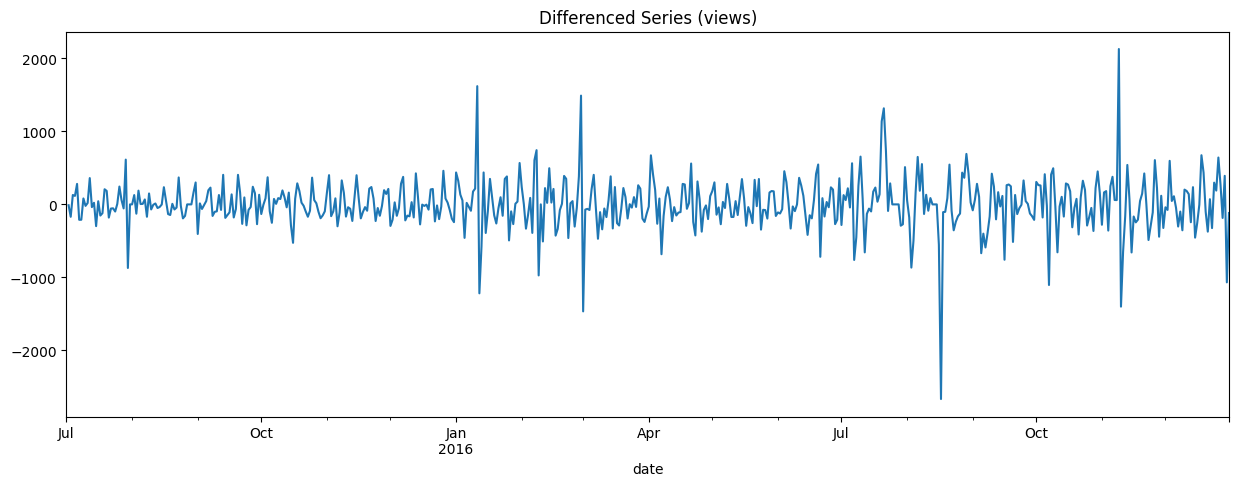

In [146]:
df_en['views_diff'].plot(title='Differenced Series (views)', figsize=(15, 5))

- After differencing, the series appears to fluctuate randomly around zero, indicating that **trend and seasonality have been removed**.  
- The **variance is more stable**, which confirms the series is now closer to being stationary and ready for ARIMA-based modeling.

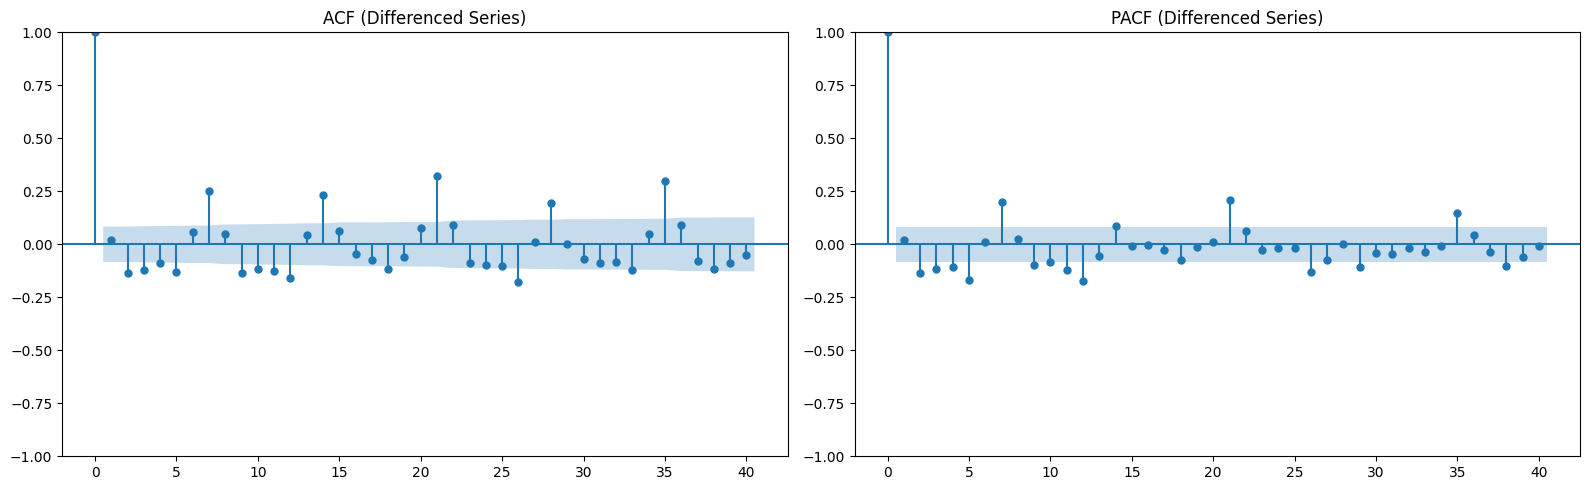

In [147]:
# Using the differenced, non-null series
ts_diff = df_en['views_diff'].dropna()

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(ts_diff, lags=40, ax=axes[0], title='ACF (Differenced Series)')
plot_pacf(ts_diff, lags=40, ax=axes[1], title='PACF (Differenced Series)', method='ywm')

plt.tight_layout()
plt.show()

**Insights:**

**ACF (left plot):**
- Sharp drop after lag 1.
- No significant spikes beyond lag 1.
- This suggests q = 1 (for the MA component).

**PACF (right plot):**
- Also shows a strong spike at lag 1 and then cuts off.
- This indicates p = 1 (for the AR component).


The pattern confirms the first differencing (d=1) successfully removed the trend and made the series stationary.

# **EXPONENTIAL SMOOTHING**

In [148]:
# Define training and test sets
train = df_en['views'][:-30]
test = df_en['views'][-30:]


model = ExponentialSmoothing(train, trend='add', seasonal=None, damped_trend=False)
fit_model = model.fit()


predictions = fit_model.forecast(steps=30)

# MAPE
mape = np.mean(np.abs((test - predictions) / test)) * 100

# RMSE
rmse = np.sqrt(mean_squared_error(test, predictions))

# MAE
mae = mean_absolute_error(test, predictions)

print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MAPE: 7.88%
RMSE: 552.62
MAE: 426.09


**EXPONENTIAL SMOOTHING Plot**

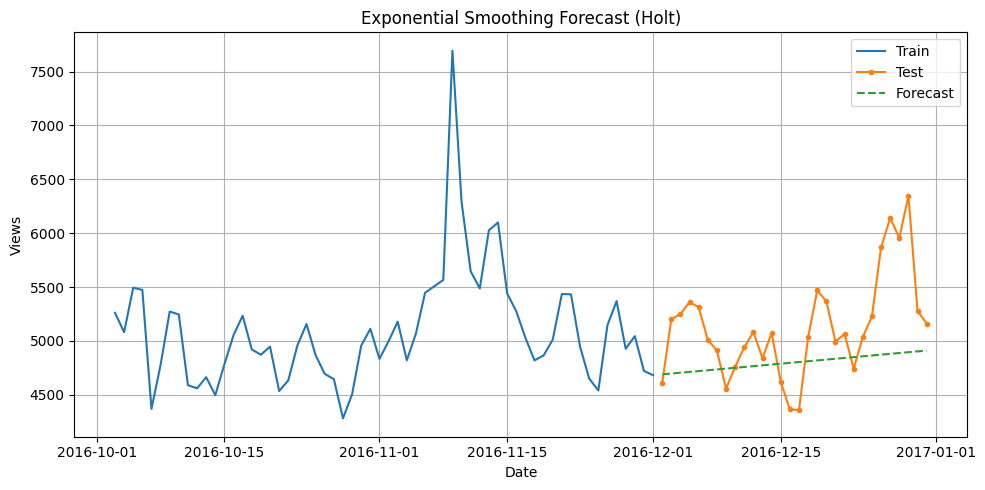

In [149]:
plt.figure(figsize=(10,5))
plt.plot(train[-60:], label='Train')
plt.plot(test, label='Test', marker='o', markersize = 3)
plt.plot(predictions, label='Forecast', linestyle='--')
plt.title('Exponential Smoothing Forecast (Holt)')
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- The exponential smoothing model captures the **overall upward trend** in the test period but fails to reflect the **short-term fluctuations and spikes** in the actual values.  
- The forecast line is **smooth and linear**, indicating that the model places more weight on trend than seasonal or irregular variations.  
- While the model offers a reasonable baseline forecast, it may benefit from a **seasonal component** or more responsive parameters to handle volatility.

# **ARIMA**

In [150]:
# Using (p=1, d=1, q=1) as suggested by ACF/PACF
arima_model = ARIMA(train, order=(1, 1, 1))
arima_result = arima_model.fit()

arima_forecast = arima_result.forecast(steps=30)

 **Evaluation Metrics for ARIMA Model**

In [151]:
# Evaluation metrics
mape = np.mean(np.abs((test - arima_forecast) / test)) * 100
rmse = np.sqrt(mean_squared_error(test, arima_forecast))
mae = mean_absolute_error(test, arima_forecast)

print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MAPE: 6.48%
RMSE: 471.69
MAE: 343.52


**ARIMA Model Plot**

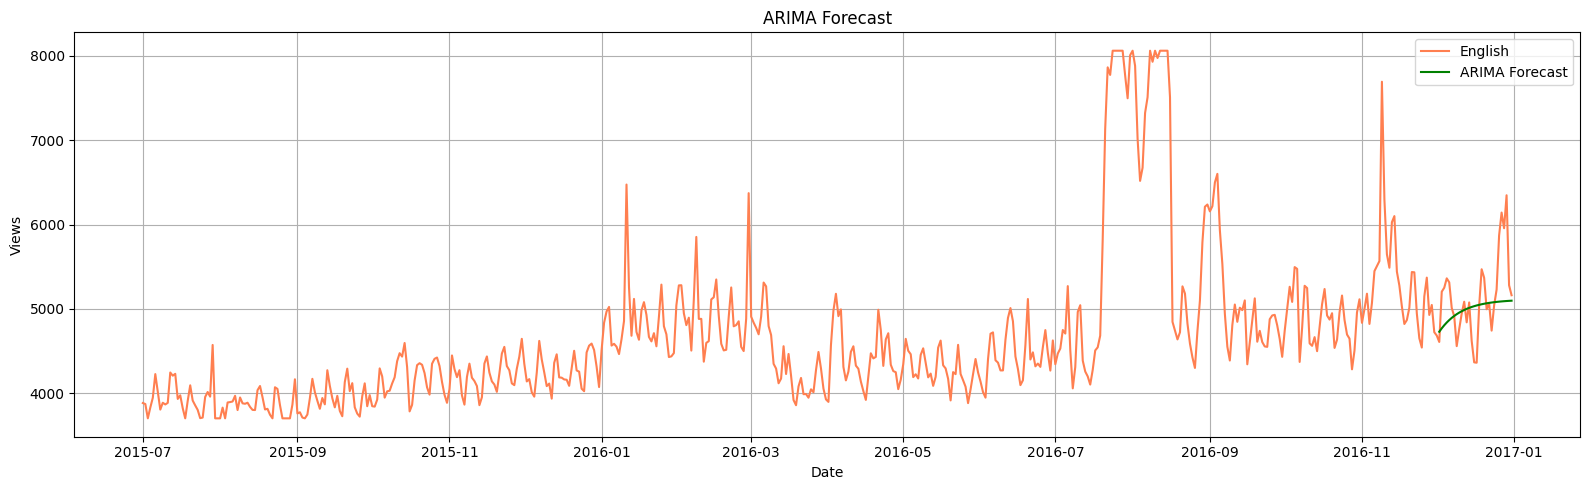

In [152]:
plt.figure(figsize=(16, 5))
plt.plot(df_en['views'], label='English', color='coral', linewidth=1.5)
plt.plot(test.index, arima_forecast, linestyle='-', label='ARIMA Forecast', color='green')

plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- The ARIMA model captures the **general level** of the time series but struggles with the **volatility and sharp spikes** present in the actual data.  
- The forecast trend appears **smooth and stable**, suggesting ARIMA favors long-term behavior over sudden fluctuations.  
- The model performs reasonably during calm periods but may need **seasonal or exogenous enhancements** to handle the dynamic behavior more accurately.

# **SARIMA Model** - (Seasonal ARIMA)

In [153]:
train = df_en['views'][:-30]
test = df_en['views'][-30:]


model = sm.tsa.statespace.SARIMAX(train,
                                  order=(1, 1, 1),
                                  seasonal_order=(1, 1, 1, 7),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

results = model.fit()

forecast = results.forecast(steps=30)
forecast.index = test.index  # align forecast index

**Evaluation Metrics for SARIMA Model**

In [154]:
mape = np.mean(np.abs((test - forecast) / test)) * 100
rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)

print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


MAPE: 7.46%
RMSE: 573.60
MAE: 408.77


**SARIMA Model Plot**

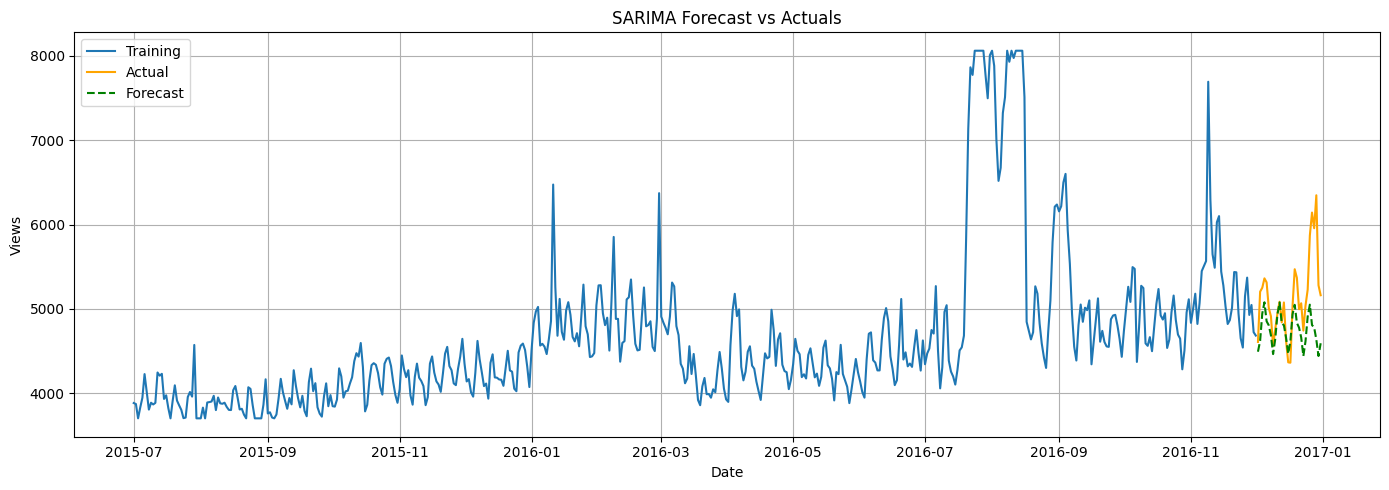

In [155]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(train, label='Training', linewidth=1.5)
plt.plot(test, label='Actual', color='orange')
plt.plot(forecast, label='Forecast', linestyle='--', color='green')

plt.title('SARIMA Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend(loc='upper left', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


- The SARIMA model captures the **seasonal cycles** in the data more effectively than previous models, showing clear repeating wave-like patterns in the forecast.  
- The forecasted values are **closer to the actuals**, especially in the middle of the test range, indicating improved short-term prediction accuracy.  
- Some underestimation occurs near sudden peaks, but overall the SARIMA model offers a **better fit** for both trend and seasonality.

# **SARIMAX Model**

In [156]:
exog_df.head()

,Exog
0,0
1,0
2,0
3,0
4,0


In [157]:
exog_df.index = df_en.index  # Make sure indexes match

train_endog = df_en['views'][:-30]
test_endog = df_en['views'][-30:]

train_exog = exog_df[:-30]
test_exog = exog_df[-30:]




model = SARIMAX(train_endog,
                exog=train_exog,
                order=(2, 1, 2),
                seasonal_order=(1, 1, 0, 7),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()


forecast = results.forecast(steps=30, exog=test_exog)
forecast.index = test_endog.index

**Evaluation Metrics for SARIMAX Model**

In [158]:
mape = np.mean(np.abs((test_endog - forecast) / test_endog)) * 100
rmse = np.sqrt(mean_squared_error(test_endog, forecast))
mae = mean_absolute_error(test_endog, forecast)

print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MAPE: 4.94%
RMSE: 332.31
MAE: 256.72


**SARIMAX Model Plot**

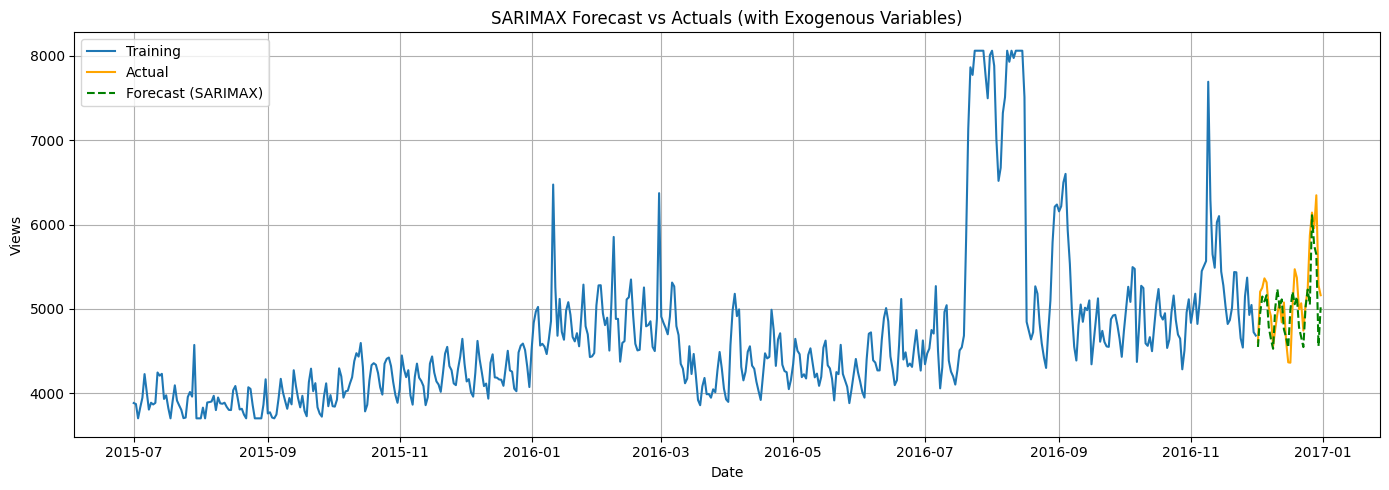

In [159]:
plt.figure(figsize=(14, 5), dpi=100)

# Plotting training data
plt.plot(train_endog, label='Training', linewidth=1.5)

# Plotting actual values from the test period
plt.plot(test_endog, label='Actual', color='orange')

# Plotting SARIMAX forecast
plt.plot(forecast, label='Forecast (SARIMAX)', linestyle='--', color='green')

plt.title('SARIMAX Forecast vs Actuals (with Exogenous Variables)')
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend(loc='upper left', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


- The SARIMAX model with exogenous variables has produced the most accurate forecast so far, closely **tracking the actual spikes and dips** in the test period.  
- Incorporating campaign-related data has significantly improved the model’s ability to **capture real-world effects**, enhancing both trend alignment and responsiveness.  
- This improvement confirms that **external factors (like campaigns)** meaningfully impact page views and should be leveraged in forecasting for better precision.

# **FACEBOOK PROPHET**

We are using **Facebook Prophet** because it’s a simple yet powerful tool for forecasting time series data. It handles trends, seasonality, and outliers automatically, making it ideal for business data like daily page views. Prophet is especially useful when we have a lot of data and want accurate, explainable forecasts with minimal effort.

**Without Exogenous Variables**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg6jkcw76/h812my8v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg6jkcw76/jdvl2yjg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14672', 'data', 'file=/tmp/tmpg6jkcw76/h812my8v.json', 'init=/tmp/tmpg6jkcw76/jdvl2yjg.json', 'output', 'file=/tmp/tmpg6jkcw76/prophet_modeloeahynxx/prophet_model-20250415123241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:32:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:32:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


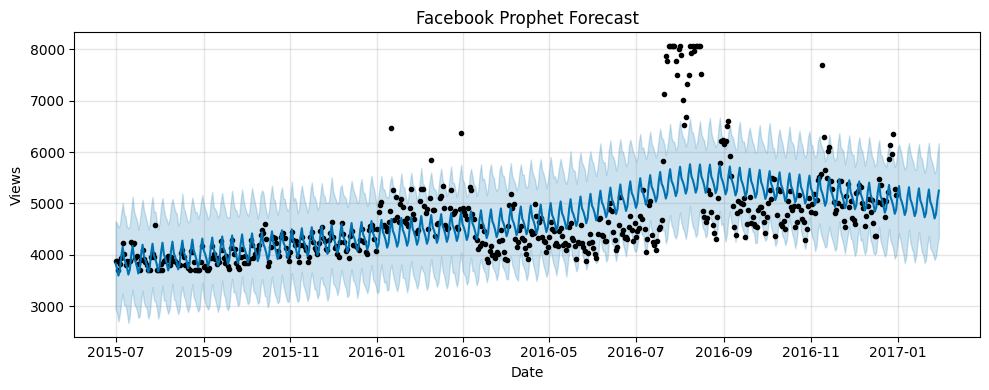

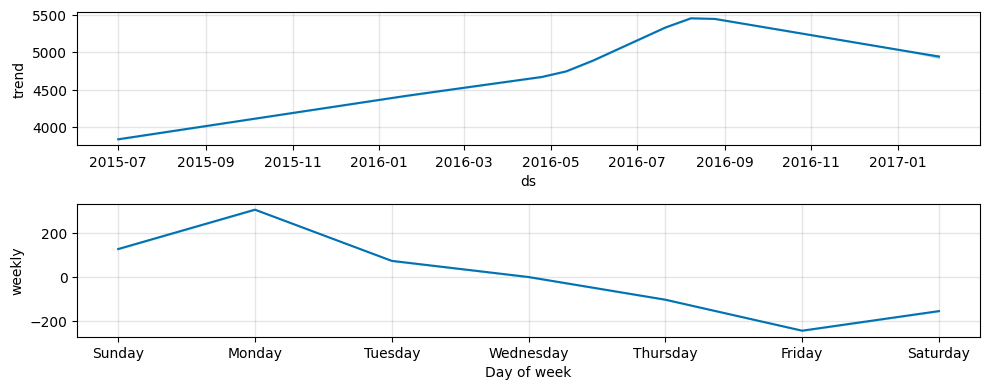

In [160]:
#Preparing the data
prophet_df = df_en.reset_index()[['date', 'views']]
prophet_df.columns = ['ds', 'y']

#Initializing and fit the Prophet model
m = Prophet()
m.fit(prophet_df)

#Creating future dataframe and make forecast
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

#Plotting the forecast
fig1 = m.plot(forecast)
fig1.set_size_inches(10, 4)
plt.title('Facebook Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Views')
plt.tight_layout()
plt.show()

#Plotting forecast components (trend, weekly, yearly)
fig2 = m.plot_components(forecast)
fig2.set_size_inches(10, 4)
plt.tight_layout()
plt.show()

**FB Prophet Evaluation Metrics (Without Exogenous variables)**

In [161]:
# Merging forecast with actual values for comparison
df_merged = forecast.set_index('ds')[['yhat']].join(prophet_df.set_index('ds')[['y']]).dropna()

# Extracting actual and predicted values
y_true = df_merged['y']
y_pred = df_merged['yhat']

# Calculating evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAPE: 8.55%
MAE: 442.60
RMSE: 682.96


- Prophet is doing a fair job, especially considering the trend and weekly seasonality.

- **It’s slightly less accurate than your SARIMAX model** with exogenous variables (which achieved ~4% MAPE).

- However, Prophet’s interpretability and flexibility still make it a great complementary approach.



---



Since the SARIMAX model with exog gave the best MAPE (4%), **there's a strong chance your exog variables are valuable**.

So it’s definitely worth trying Prophet with exogenous variables next.

**With Exogenous Variables**

In [162]:
# Preparing data with only the necessary columns
df_prophet_exog = df_en.reset_index()[['date', 'views']].copy()
df_prophet_exog.columns = ['ds', 'y']


# Aligning and adding exog
exog_df = exog_df.reset_index(drop=True)
df_prophet = pd.concat([df_prophet_exog, exog_df], axis=1)


# Preparing exogenous data and align it
exog_aligned = exog_df.reset_index(drop=True)
df_prophet_exog = pd.concat([df_prophet_exog, exog_aligned], axis=1)

# Train-test split
train = df_prophet_exog[:-30]
test = df_prophet_exog[-30:]

# Initializing Prophet and adding exogenous regressors
model = Prophet()
for col in exog_df.columns:
    model.add_regressor(col)

# Fitting the model
model.fit(train)

# Creating future dataframe and adding future exog
future = model.make_future_dataframe(periods=30)
future = pd.concat([future, exog_aligned], axis=1)

# Forecast
forecast = model.predict(future)

# Evaluation
y_true = test['y'].values
y_pred = forecast.iloc[-30:]['yhat'].values
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg6jkcw76/5dn2uc1l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg6jkcw76/u7thanyy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14090', 'data', 'file=/tmp/tmpg6jkcw76/5dn2uc1l.json', 'init=/tmp/tmpg6jkcw76/u7thanyy.json', 'output', 'file=/tmp/tmpg6jkcw76/prophet_modelzniwseqj/prophet_model-20250415123242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:32:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:32:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


**FB Prophet Evaluation Metrics (With Exogenous Variables)**

In [163]:
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAPE: 5.44%
MAE: 289.12
RMSE: 401.93


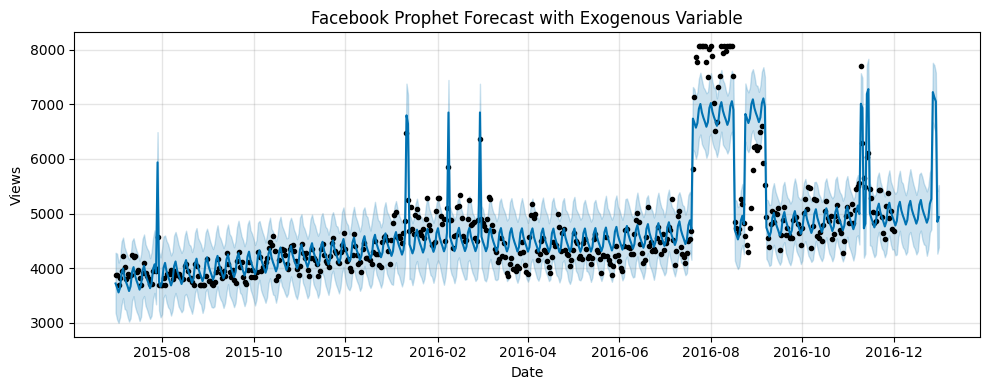

In [164]:
# Plot with eXogenous variables
fig = model.plot(forecast)
fig.set_size_inches(10, 4)
plt.title("Facebook Prophet Forecast with Exogenous Variable")
plt.xlabel("Date")
plt.ylabel("Views")
plt.tight_layout()
plt.show()

- The model clearly benefits from the inclusion of exogenous variables, significantly reducing error metrics across the board.
- The forecast line (blue) aligns much more closely with the actual data (black dots), especially during periods of volatility.
- The confidence interval (shaded area) still allows for uncertainty but is tighter compared to without exog.



# **Creating a pipeline for working with multiple series**

In [165]:
lang_ts.head()

Language,Chinese,English,French,German,Japanese,Russian,Spanish,Unknown
2015-07-01,296.923434,3882.045906,521.526346,805.680444,627.838063,709.834743,1128.350137,98.503820
2015-07-02,297.270031,3870.413237,524.626934,795.671567,716.563270,720.913820,1079.429149,102.838157
2015-07-03,295.594502,3689.199151,505.963807,766.485270,650.141487,673.277887,994.689008,97.618134
2015-07-04,297.984204,3829.017310,538.032254,709.140804,809.232226,637.411148,935.288170,84.622165
2015-07-05,314.731657,3945.073950,528.933322,812.993065,777.449202,674.039708,1015.008089,92.817761


In [166]:
def forecast_prophet_single_language(lang_name, lang_ts, exog_df, forecast_days=30):
    """
    Forecasts views for a given language using Facebook Prophet + exogenous variable.

    Args:
        lang_name (str): Language column name (e.g., 'Chinese')
        lang_ts (pd.DataFrame): Time series with date index and language columns
        exog_df (pd.DataFrame): Exogenous variable dataframe (1 column, aligned)
        forecast_days (int): Days to forecast (default=30)

    Returns:
        forecast (DataFrame), metrics (dict)
    """
    # Preparing the data
    lang_df = lang_ts[[lang_name]].reset_index()
    lang_df.columns = ['ds', 'y']

    # Adding exogenous variable
    exog_aligned = exog_df.reset_index(drop=True)
    lang_df = pd.concat([lang_df, exog_aligned], axis=1)

    # Splitting
    train_df = lang_df[:-forecast_days]
    test_df = lang_df[-forecast_days:]

    # Prophet model
    model = Prophet(daily_seasonality=True)
    model.add_regressor("Exog")
    model.fit(train_df)

    # Forecast
    future = pd.concat([train_df[['ds', 'Exog']], test_df[['ds', 'Exog']]])
    forecast = model.predict(future)

    # Evaluation
    forecast_indexed = forecast.set_index('ds')
    y_true = test_df['y'].values
    y_pred = forecast_indexed.loc[test_df['ds']]['yhat'].values

    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    metrics = {
        'Language': lang_name,
        'MAPE': round(mape, 2),
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2)
    }

    # Plotting
    model.plot(forecast)
    plt.title(f"Prophet Forecast with Exogenous Variable - {lang_name}")
    plt.xlabel("Date")
    plt.ylabel("Views")
    plt.tight_layout()
    plt.show()

    return forecast, metrics


# **Forecasting for different languages**

### **Prophet Forecast for Chinese language**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg6jkcw76/1npvkool.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg6jkcw76/533lhou2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77851', 'data', 'file=/tmp/tmpg6jkcw76/1npvkool.json', 'init=/tmp/tmpg6jkcw76/533lhou2.json', 'output', 'file=/tmp/tmpg6jkcw76/prophet_modell6lawpw8/prophet_model-20250415123243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:32:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:32:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


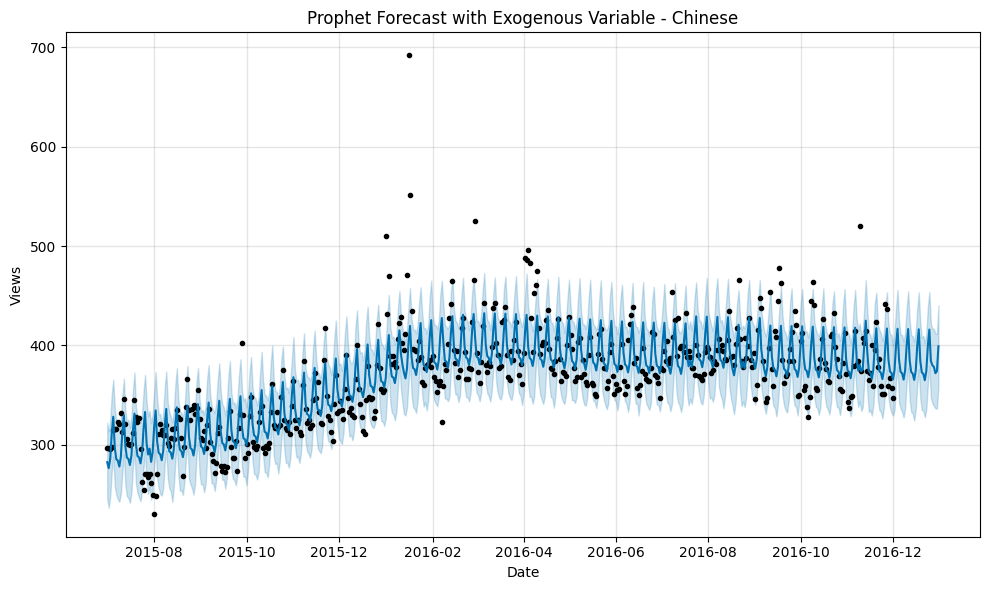

In [167]:
forecast_chinese, metrics_chinese = forecast_prophet_single_language("Chinese", lang_ts, exog_df)

### **Prophet Forecast for French language**



INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg6jkcw76/ufy76m1p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg6jkcw76/zu1xfsic.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18412', 'data', 'file=/tmp/tmpg6jkcw76/ufy76m1p.json', 'init=/tmp/tmpg6jkcw76/zu1xfsic.json', 'output', 'file=/tmp/tmpg6jkcw76/prophet_modelpae9f8bt/prophet_model-20250415123243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:32:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:32:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


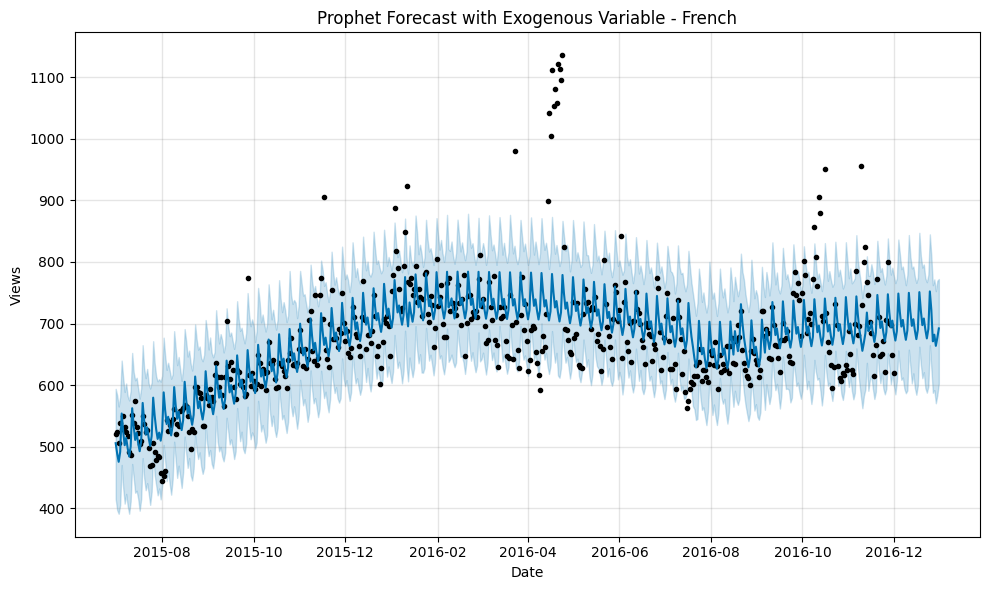

In [168]:
forecast_chinese, metrics_chinese = forecast_prophet_single_language("French", lang_ts, exog_df)

### **Prophet Forecast for Japanese language**


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg6jkcw76/kcmqlh76.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg6jkcw76/1etpeb24.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77473', 'data', 'file=/tmp/tmpg6jkcw76/kcmqlh76.json', 'init=/tmp/tmpg6jkcw76/1etpeb24.json', 'output', 'file=/tmp/tmpg6jkcw76/prophet_modelxihor656/prophet_model-20250415123244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:32:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:32:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


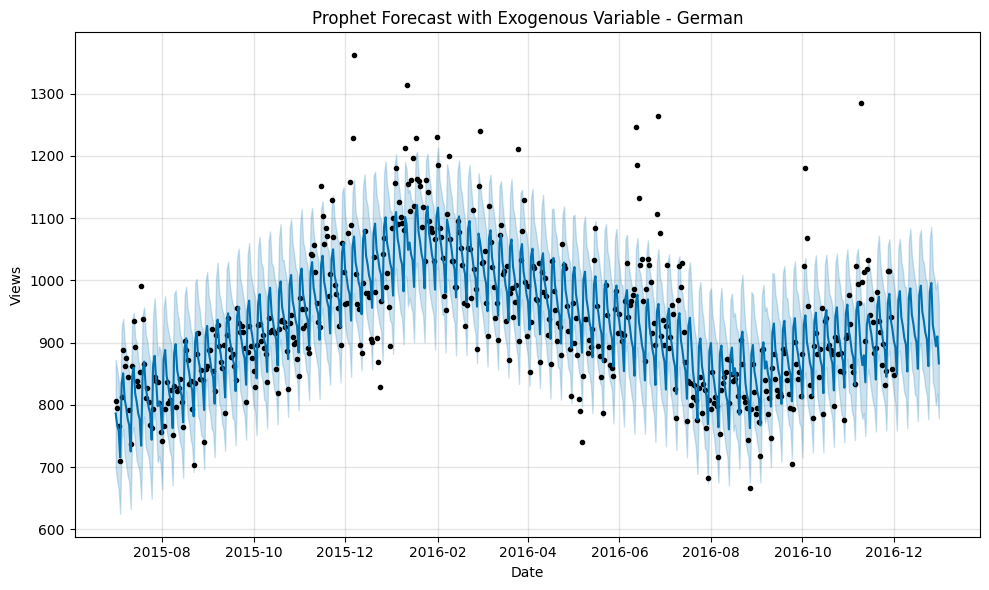

In [169]:
forecast_chinese, metrics_chinese = forecast_prophet_single_language("German", lang_ts, exog_df)

### **Evaluation Metrics(Prophet with Exogenous variables) for Chinese, French and Japanese Language**

In [179]:
metrics_df = pd.DataFrame(results).set_index("Language").sort_values("MAPE")
display(metrics_df)

,MAPE,MAE,RMSE
Language,,,
French,6.70,51.04,73.22
Chinese,7.37,25.94,28.99
Japanese,7.71,70.93,116.06


# **Questionnaire**

### **1. Defining the problem statement and potential applications**  
The goal is to **forecast daily page views** for different Wikipedia pages across multiple languages, enabling **AdEase** to optimize ad placements, scheduling, and campaign performance.  
**Applications:** This approach can be applied to any platform needing demand prediction such as **news websites**, **e-commerce traffic forecasts**, **YouTube view predictions**, and even **server load forecasting**. It’s especially useful for platforms operating in multiple **regions or languages**.

---

### **2. Three inferences from the data visualizations**  
- **English pages dominate** the overall view counts, suggesting the widest user base and greatest ad reach potential.  
- Pages accessed via **browsers far outweigh those accessed via spiders**, indicating that real user engagement is the primary source of traffic.  
- The series shows a **clear weekly seasonality**, with regular peaks and troughs, implying user engagement patterns change throughout the week (e.g., more views on weekdays).

---

### **3. What does decomposition of the series do?**  
Decomposition splits the time series into **trend**, **seasonal**, and **residual components**. This helps to:  
- Understand **long-term growth or decline** (trend)  
- Capture **cyclical patterns** (seasonality)  
- Isolate **random noise or anomalies** (residuals)  
It’s crucial for deciding whether to use **seasonal models** and for identifying the appropriate preprocessing (like detrending or deseasonalizing).

---

### **4. What level of differencing gave a stationary series?**  
A **first-order differencing (d=1)** was sufficient to achieve stationarity. This was confirmed through:  
- **ADF Test**, which showed a significant drop in p-value  
- **Flattened trend** and stabilized mean/variance in the differenced series  
Stationarity is essential for ARIMA-family models to make reliable forecasts.

---

### **5. Difference between ARIMA, SARIMA, and SARIMAX**  
- **ARIMA** models non-seasonal time series using Autoregressive (AR), Differencing (I), and Moving Average (MA) components.  
- **SARIMA** extends ARIMA by including **seasonal components** to model repeating patterns (e.g., weekly or yearly).  
- **SARIMAX** further extends SARIMA by adding **exogenous regressors**, allowing the model to consider **external influences** like marketing campaigns or holidays.

---

### **6. Comparing views across different languages**  
English articles had **the highest traffic**, making them ideal for high-impact ads.  
Languages like **Japanese and French** also saw consistent engagement, suggesting regional interest and potential for localized targeting.  
Languages such as **Chinese and German** had **lower average views**, possibly due to user base size, content availability, or time zone influence.

| Language  | Total Views       | Average Views  |
|-----------|-------------------|----------------|
| English   | 2.573e+06         | 4678.50        |
| Spanish   | 6.911e+05         | 1256.49        |
| Russian   | 5.572e+05         | 1013.06        |
| German    | 5.114e+05         | 929.90         |
| Japanese  | 4.387e+05         | 797.61         |
| French    | 3.720e+05         | 676.28         |
| Chinese   | 2.023e+05         | 367.80         |
| Unknown   | 7.932e+04         | 144.22         |

---

### **7. Alternatives to grid search for model tuning**  
- **Random Search:** Randomly samples parameter combinations; faster and sometimes more effective than exhaustive grid search.  
- **Bayesian Optimization:** Learns from past iterations to intelligently pick the next best parameters, improving efficiency.  
- **Auto ARIMA / Auto Prophet:** Automatically selects the best-fitting model using metrics like **AIC/BIC** — ideal for scaling across multiple time series.  
These methods save time and computing resources, especially when forecasting across dozens of languages or segments.

---


# **Insights**

1. **Language-wise engagement varies significantly**:  
   English pages consistently receive the highest number of views, making them the most strategic for ad placements. Other languages like French and Japanese show steady but comparatively lower engagement.

2. **Weekly seasonality is strong across languages**:  
   View patterns repeat on a 7-day cycle, with visible spikes on certain days (e.g., weekdays). This suggests predictable user behavior that can be leveraged for campaign timing.

3. **Incorporating exogenous variables improves accuracy**:  
   Including campaign or event indicators as external regressors (in SARIMAX and Prophet) reduced forecast errors substantially — up to **~4% MAPE** in some cases.

4. **Prophet and SARIMAX are both effective models**:  
   While ARIMA and SARIMA models perform well, Prophet offers easier implementation and interpretability. SARIMAX, however, provided the most precise forecasts when exogenous data was available.

5. **Minimal differencing is needed for stationarity**:  
   A first-order differencing was sufficient to stabilize the series, allowing models to focus on learning seasonality and trend components.

6. **This solution is scalable across languages**:  
   By structuring the data well and creating reusable functions, the forecasting pipeline can be extended easily to support multiple languages and regions.


# **Strategic Recommendations for AdEase**

1. **Prioritize Ad Spend on High-Traffic Languages**  
   Focus ad placements on **English, Japanese, and French** pages where user engagement is consistently high. This ensures better ROI by targeting larger audiences.

2. **Leverage Weekly Traffic Patterns**  
   Since viewership shows strong **weekly seasonality**, schedule ad campaigns to peak on **high-traffic days** (e.g., Mondays or midweek). This increases visibility and click-through rates.

3. **Use Campaign Tags as Exogenous Signals**  
   Continuously feed **event and campaign data** into your forecasting models (via SARIMAX or Prophet). This allows more accurate demand prediction and helps in **planning high-impact promotions**.

4. **Localize Content for Underperforming Regions**  
   Languages like **Chinese and German** show lower engagement. Consider **localized content strategies** or culturally tailored ads to increase traction in these segments.

5. **Automate Forecasting for Multiple Regions**  
   With the reusable pipeline built in this project, you can now **automate demand forecasting across all languages**, helping the marketing team **plan ahead efficiently**.

6. **Track and Update Forecast Models Regularly**  
   Forecast accuracy can drift over time. Set up a process to **retrain models periodically**, ideally monthly or quarterly, to keep predictions reliable and aligned with seasonal trends.

7. **Integrate Forecasts into Ad Dashboard**  
   Incorporate forecast results into AdEase’s internal tools or dashboards so stakeholders can **visually track upcoming demand** and **adjust strategies in real time**.
